In [1]:
import sys
sys.path.append('../mast3r')
sys.path.append('../dust3r')

In [2]:
import cv2
import numpy as np

import torch
import torchvision.transforms.functional
# from matplotlib import pyplot as pl
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [3]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


/home/user/javeda1/miniconda3/envs/mast3r/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda'
schedule = 'cosine'
lr = 0.01
niter = 300

In [5]:
img1_path = '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png'
img2_path = '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png'

In [6]:
model_name = "../naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

... loading model from ../naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


In [7]:
images = load_images([img1_path, img2_path], size=512)
output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

# at this stage, you have the raw dust3r predictions
view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

>> Loading a list of 2 images
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png with resolution 1920x650 --> 512x160
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png with resolution 1920x650 --> 512x160
 (Found 2 images)


/home/user/javeda1/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/user/javeda1/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/user/javeda1/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [8]:
# find 2D-2D matches between the two images
matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                               device=device, dist='dot', block_size=2**13)

In [9]:
# ignore small border around the edge
H0, W0 = view1['true_shape'][0]
valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
    matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

H1, W1 = view2['true_shape'][0]
valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
    matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

valid_matches = valid_matches_im0 & valid_matches_im1
matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

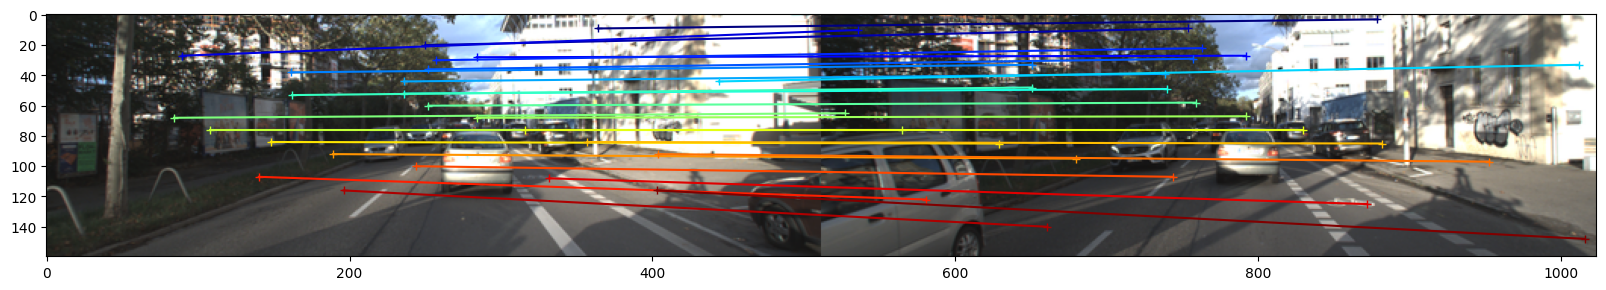

In [10]:
n_viz = 25
num_matches = matches_im0.shape[0]
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

viz_imgs = []
for i, view in enumerate([view1, view2]):
    rgb_tensor = view['img'] * image_std + image_mean
    viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img = np.concatenate((img0, img1), axis=1)
plt.figure(figsize=(20, 15))
plt.imshow(img)
cmap = plt.get_cmap('jet')
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    plt.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
plt.show(block=True)

In [11]:
pts1 = matches_im0.astype(np.float32)  # Points from Image 1
pts2 = matches_im1.astype(np.float32)  # Corresponding points in Image 2

In [12]:
# Compute Fundamental Matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC, ransacReprojThreshold=1.0, confidence=0.999)

In [13]:
F

array([[-6.74867196e-04, -5.65645773e-01,  4.13849069e+01],
       [ 5.66275409e-01,  9.10094687e-03, -1.53245961e+02],
       [-4.05127584e+01,  1.49846147e+02,  1.00000000e+00]])

In [14]:
# Compute Essential Matrix from F (assuming unit focal length)
E = np.dot(F.T, F)

# Decompose Essential Matrix to get Rotation (R) and Translation (t)
_, R, t, mask = cv2.recoverPose(E, pts1, pts2)

In [15]:
print("Estimated Rotation (R):\n", R)
print("Estimated Translation (t):\n", t)

Estimated Rotation (R):
 [[ 9.31882910e-01  2.48340354e-01  2.64426379e-01]
 [ 2.55505617e-01  6.81042543e-02 -9.64405874e-01]
 [-2.57509457e-01  9.66275778e-01  1.28352494e-05]]
Estimated Translation (t):
 [[-0.96534083]
 [-0.26096792]
 [-0.00358263]]


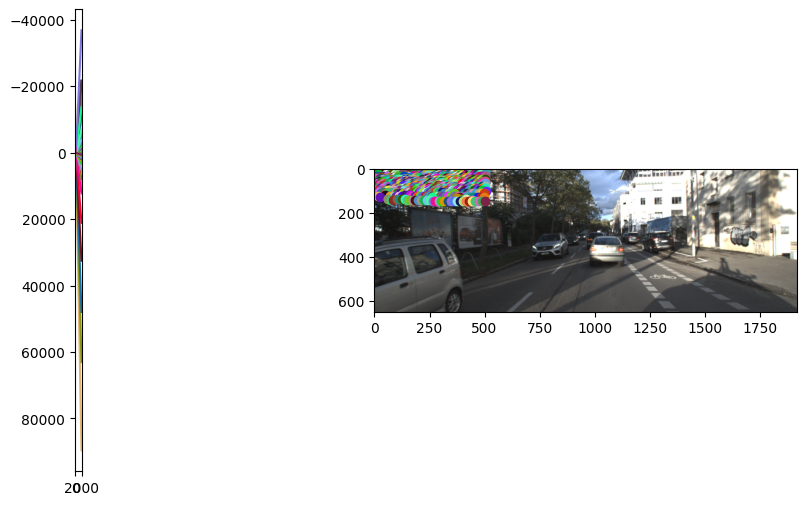

In [16]:
def draw_epipolar_lines(F, img1, img2, pts1, pts2):
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img1)
    axes[1].imshow(img2)

    for line, pt1, pt2 in zip(lines1, pts1, pts2):
        color = np.random.rand(3,)
        x0, y0 = map(int, [0, -line[2] / line[1]])
        x1, y1 = map(int, [img1.shape[1], -(line[2] + line[0] * img1.shape[1]) / line[1]])
        axes[0].plot([x0, x1], [y0, y1], color=color)
        axes[0].scatter(pt1[0], pt1[1], color=color)
        axes[1].scatter(pt2[0], pt2[1], color=color)

    plt.show()

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
draw_epipolar_lines(F, img1, img2, pts1, pts2)

In [17]:
# matched keypoints
kp1 = matches_im0.astype(np.float32)
kp2 = matches_im1.astype(np.float32)

# If you do not know the camera intrinsics at all, you can use findEssentialMat 
# in the "calibrated" = false sense, so that it also tries to solve for the focal scale.
E, mask = cv2.findEssentialMat(
    kp1, kp2,
    focal=1.0,  # initial guess
    pp=(0.,0.), # assume principal point ~ center (or offset if needed)
    method=cv2.RANSAC, 
    prob=0.999, 
    threshold=1.0
)
R1, R2, t = cv2.decomposeEssentialMat(E)

In [18]:
R1

array([[ 0.85080334,  0.52543734,  0.0070193 ],
       [ 0.52543628, -0.85083025,  0.00214303],
       [ 0.00709826,  0.0018649 , -0.99997307]])

In [19]:
R2

array([[ 9.99991802e-01, -4.04884134e-03, -4.59069681e-05],
       [ 4.04883450e-03,  9.99991792e-01, -1.48042290e-04],
       [ 4.65059910e-05,  1.47855207e-04,  9.99999988e-01]])

In [20]:
t

array([[0.96142307],
       [0.27504892],
       [0.00371145]])

In [21]:
objPoints = []
imgPoints = []
for (x1,y1),(x2,y2) in zip(matches_im0, matches_im1):
    X3d = pred1["pts3d"][0, int(y1), int(x1)]   # shape (3,)
    objPoints.append(X3d.cpu().numpy())
    imgPoints.append([x2, y2])
objPoints = np.array(objPoints, dtype=np.float32)
imgPoints = np.array(imgPoints, dtype=np.float32)

# If you do not know intrinsics, you have at least to guess a principal point 
# or do a more advanced approach. If you do have partial intrinsics (like principal point),
# you can set fx,fy = 1 for now, then treat it like self-cal, or do a “bundle adjustment.”
K = np.array([
    [510.10, 0, 315.85],
    [0, 510.37, 253.19],
    [0, 0, 1]
], dtype=np.float32)
distCoeffs = np.zeros(5)

success, rvec, tvec, inliers = cv2.solvePnPRansac(
    objPoints, 
    imgPoints, 
    K, 
    distCoeffs, 
    flags=cv2.SOLVEPNP_ITERATIVE 
)

R,_ = cv2.Rodrigues(rvec)
# R,t is camera2 pose in camera1’s coords

In [22]:
R

array([[ 0.99247768,  0.00748331, -0.1221968 ],
       [-0.04319937,  0.95533234, -0.29235925],
       [ 0.11455074,  0.29543886,  0.9484693 ]])

In [23]:
t

array([[0.96142307],
       [0.27504892],
       [0.00371145]])